In [1]:
import itertools
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt 
#%matplotlib inline

import qiskit
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import I, X, Y, Z, PauliSumOp
from qiskit.algorithms import VQE, QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer

/home/keisuke/miniconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


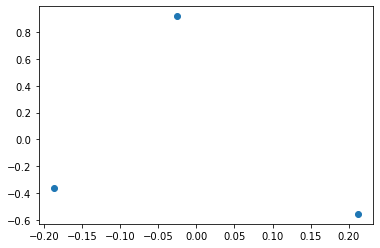

In [2]:
from docplex.mp.model import Model
from sklearn import manifold
from matplotlib import pyplot as plt

N = 3 # # of scatters
D = np.random.rand(N*N).reshape(N,N)

D = D.T + D # Distance Matrix
for n in range(N):
    D[n,n] = 0
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
pos = mds.fit_transform(D)

fig = plt.figure()
plt.scatter(x = pos[:,0], y = pos[:,1])

In [3]:
def get_num(n1,n2,N):
           
    assert n1 != n2
    
    sub = 0
    if n1<n2:
        sub = 1
    
    
    return (N-1) * n1 + n2 - sub

def from_num(num,N):
    
    n1 = num//(N-1)
    
    n2 = num%(N-1)
    
    if n2 > n1-1:
        n2+=1
    return n1, n2

In [4]:
D_ = np.zeros(int(N*(N-1)))

for n1 in range(N):
    for n2 in range(N):
        if n1==n2:
            continue
        D_[get_num(n2,n1,N)] = D[n2,n1]

### MIP form of TSP

$$
i, j  \in \{0,..,N-1\} \\ \\
\text{optimize} \sum_{i,j} D_{ij}x_{ij}\\
\text{under the constraints} \\\sum_i x_{ij} = 1 \\\sum_j x_{ij} = 1\\
t_i - t_j + nx_{ij} <= n-1,\ \ \ 1<= i \neq j<=n-1
$$

In [87]:
mod = Model('TSP')
var = [mod.binary_var(name=f'x{i}') for i in range(N*(N-1))]
t = [mod.integer_var(name=f't{n+1}',lb=0, ub=2*N) for n in range(N-1)]
mod.maximize(mod.sum(D_[i] * var[i] for i in G.nodes()))

constraint = []
for n1 in range(N):
    constraint1 = []
    constraint2 = []
    for n2 in range(N):
        if n1!=n2:
            constraint1.append(var[get_num(n1,n2,N)])
            constraint2.append(var[get_num(n2,n1,N)])
    mod.add_constraint(mod.sum(constraint1)==1)
    mod.add_constraint(mod.sum(constraint2)==1)
    
# constraints for not creating subloops

for i in range(1,N):
    for j in range(1,N):
        if i!=j:
            mod.add_constraint(t[i-1]-t[j-1]+N*var[get_num(i,j,N)] <= N-1)
        


    

In [91]:
from qiskit_optimization.converters import InequalityToEquality
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.converters import IntegerToBinary

qp = QuadraticProgram()
qp.from_docplex(mod)

In [92]:
ineq2eq = InequalityToEquality()
qp_eq = ineq2eq.convert(qp)
\
lineq2penalty = LinearEqualityToPenalty()
qubo = lineq2penalty.convert(qp_eq)

int2bin = IntegerToBinary()
qp_eq_bin = int2bin.convert(qubo)

In [103]:
H, offset = qp_eq_bin.to_ising()

seed = 1000
maxiter = 500
maxiter2 = 500

In [119]:
# ansatz = TwoLocal(H.num_qubits, ['ry','rz'], 'cx', entanglement='circular', reps=1, insert_barriers=True)

# qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter2), quantum_instance=ins, reps=3)

seed = 1234
maxiter=50
algorithm_globals.random_seed = seed
ins = QuantumInstance(backend=Aer.get_backend('aer_simulator'), shots=2000, seed_simulator=seed, seed_transpiler=seed)

vqe = VQE(optimizer=COBYLA(maxiter=maxiter), quantum_instance=ins)
min_eigen_optimizer = MinimumEigenOptimizer(vqe)
result = min_eigen_optimizer.solve(qp_eq_bin)

In [120]:
solution = []

for i in range(N*(N-1)):
    solution.append(int(result.variables_dict[f"x{i}"]))

In [1]:
result.variables_dict[f"x{i}"]

NameError: name 'result' is not defined

In [117]:
solution

[0, 1, 1, 0, 0, 0]

In [105]:
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp_eq_bin)
print(result)
varnames = [v.name for v in result.variables]
for sample in result.samples:
    x = [int(x) for x in sample.x]
    print(f'cost {sample.fval}, prob {sample.probability:.5f}, {dict(zip(varnames, x))}')
draw_sol(G, [int(x) for x in result.x], pos)  # need to convert float to int

optimal function value: -13.170789274749254
optimal value: [0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.]
status: SUCCESS
cost -13.170789274749254, prob 0.00098, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 0, 't1@0': 0, 't1@1': 0, 't1@2': 1, 't2@0': 1, 't2@1': 0, 't2@2': 1, 'c6@int_slack@0': 0, 'c6@int_slack@1': 1, 'c6@int_slack@2': 0, 'c6@int_slack@3': 1, 'c7@int_slack@0': 0, 'c7@int_slack@1': 0, 'c7@int_slack@2': 0, 'c7@int_slack@3': 1}
cost -14.014578006279692, prob 0.00098, {'x0': 0, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 1, 'x5': 0, 't1@0': 1, 't1@1': 1, 't1@2': 0, 't2@0': 1, 't2@1': 0, 't2@2': 1, 'c6@int_slack@0': 0, 'c6@int_slack@1': 1, 'c6@int_slack@2': 0, 'c6@int_slack@3': 1, 'c7@int_slack@0': 0, 'c7@int_slack@1': 0, 'c7@int_slack@2': 0, 'c7@int_slack@3': 1}
cost -18.898688188675408, prob 0.00098, {'x0': 1, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 1, 'x5': 0, 't1@0': 1, 't1@1': 1, 't1@2': 0, 't2@0': 0, 't2@1': 0, 't2@2': 1, 'c6@int_slack@0': 0, 'c6@int_slack@1': 1, 'c

NameError: name 'draw_sol' is not defined

In [101]:

algorithm_globals.random_seed=seed
ins = QuantumInstance(backend=Aer.get_backend('aer_simulator'), seed_simulator=seed, seed_transpiler=seed)
vqe = VQE(optimizer=COBYLA(maxiter=maxiter), quantum_instance=ins, ansatz=ansatz)
result = vqe.compute_minimum_eigenvalue(H)
print(result)
print('ground state energy', result.optimal_value)

KeyboardInterrupt: 